# Description
Fitting b1 and beta for different density bins by minimizing $\chi^2$. Based on ideas laid out in `Fitting_b1_different_kmax.ipynb`.

The 2D power spectrum for each density bin has been computed and stored by `power_densitybins.py`. Here the data is loaded and the multipoles are deduced.

The reason to divide the sample into density bins is to later analyze the cross correlation between the subsamples to investigate relativistic effects.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.special import legendre
from scipy.integrate import simpson
from scipy.linalg import pinv
import scipy.sparse as ss

import cat_power_algos as catpk
import classylss
import fitsio
from nbodykit.lab import *
from nbodykit import style, setup_logging
#setup_logging()
plt.style.use(style.notebook)

In [5]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('/home/jwack/main/Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu') # matter power spectrum 

kmin, kmax, dk = 0, 0.05, 0.01
Nmesh = 128

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8, w0_fld, wa_fld
  self.engine = ClassEngine(pars)
/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


### Load in data and find multipoles
Multipoles stored as columns of `Pk_ells`.

Note that we only need to subtract the shotnoise from the monopole as the shotnoise is constant wrt to $\mu$, making it proportional to the 0th Legendre polynomial. Due to the orthogonality of Legendre polynomials, this term only effects the $l=0$ pole.

In [6]:
ptile_split = np.loadtxt('density_bins/percentile_edges.txt')

ells = [0,2]
n_ptile = len(ptile_split)-1 # number of bins = number of edges - 1
Pk_ells = np.empty((n_ptile, len(ells)), dtype='object') # each column contains multipole of all percentiles

for i in range(n_ptile):
    r = FFTPower.load('density_bins/ptile_%d.json'%i)
    poles = r.poles 
    mus = r.power.coords['mu']

    for j,ell in enumerate(ells):
        Pk_ell = poles['power_%d' %ell].real
        if ell == 0: 
            Pk_ell = Pk_ell - poles.attrs['shotnoise']
            
        Pk_ells[i][j] = Pk_ell

k = poles['k']
shotnoise = poles.attrs['shotnoise']

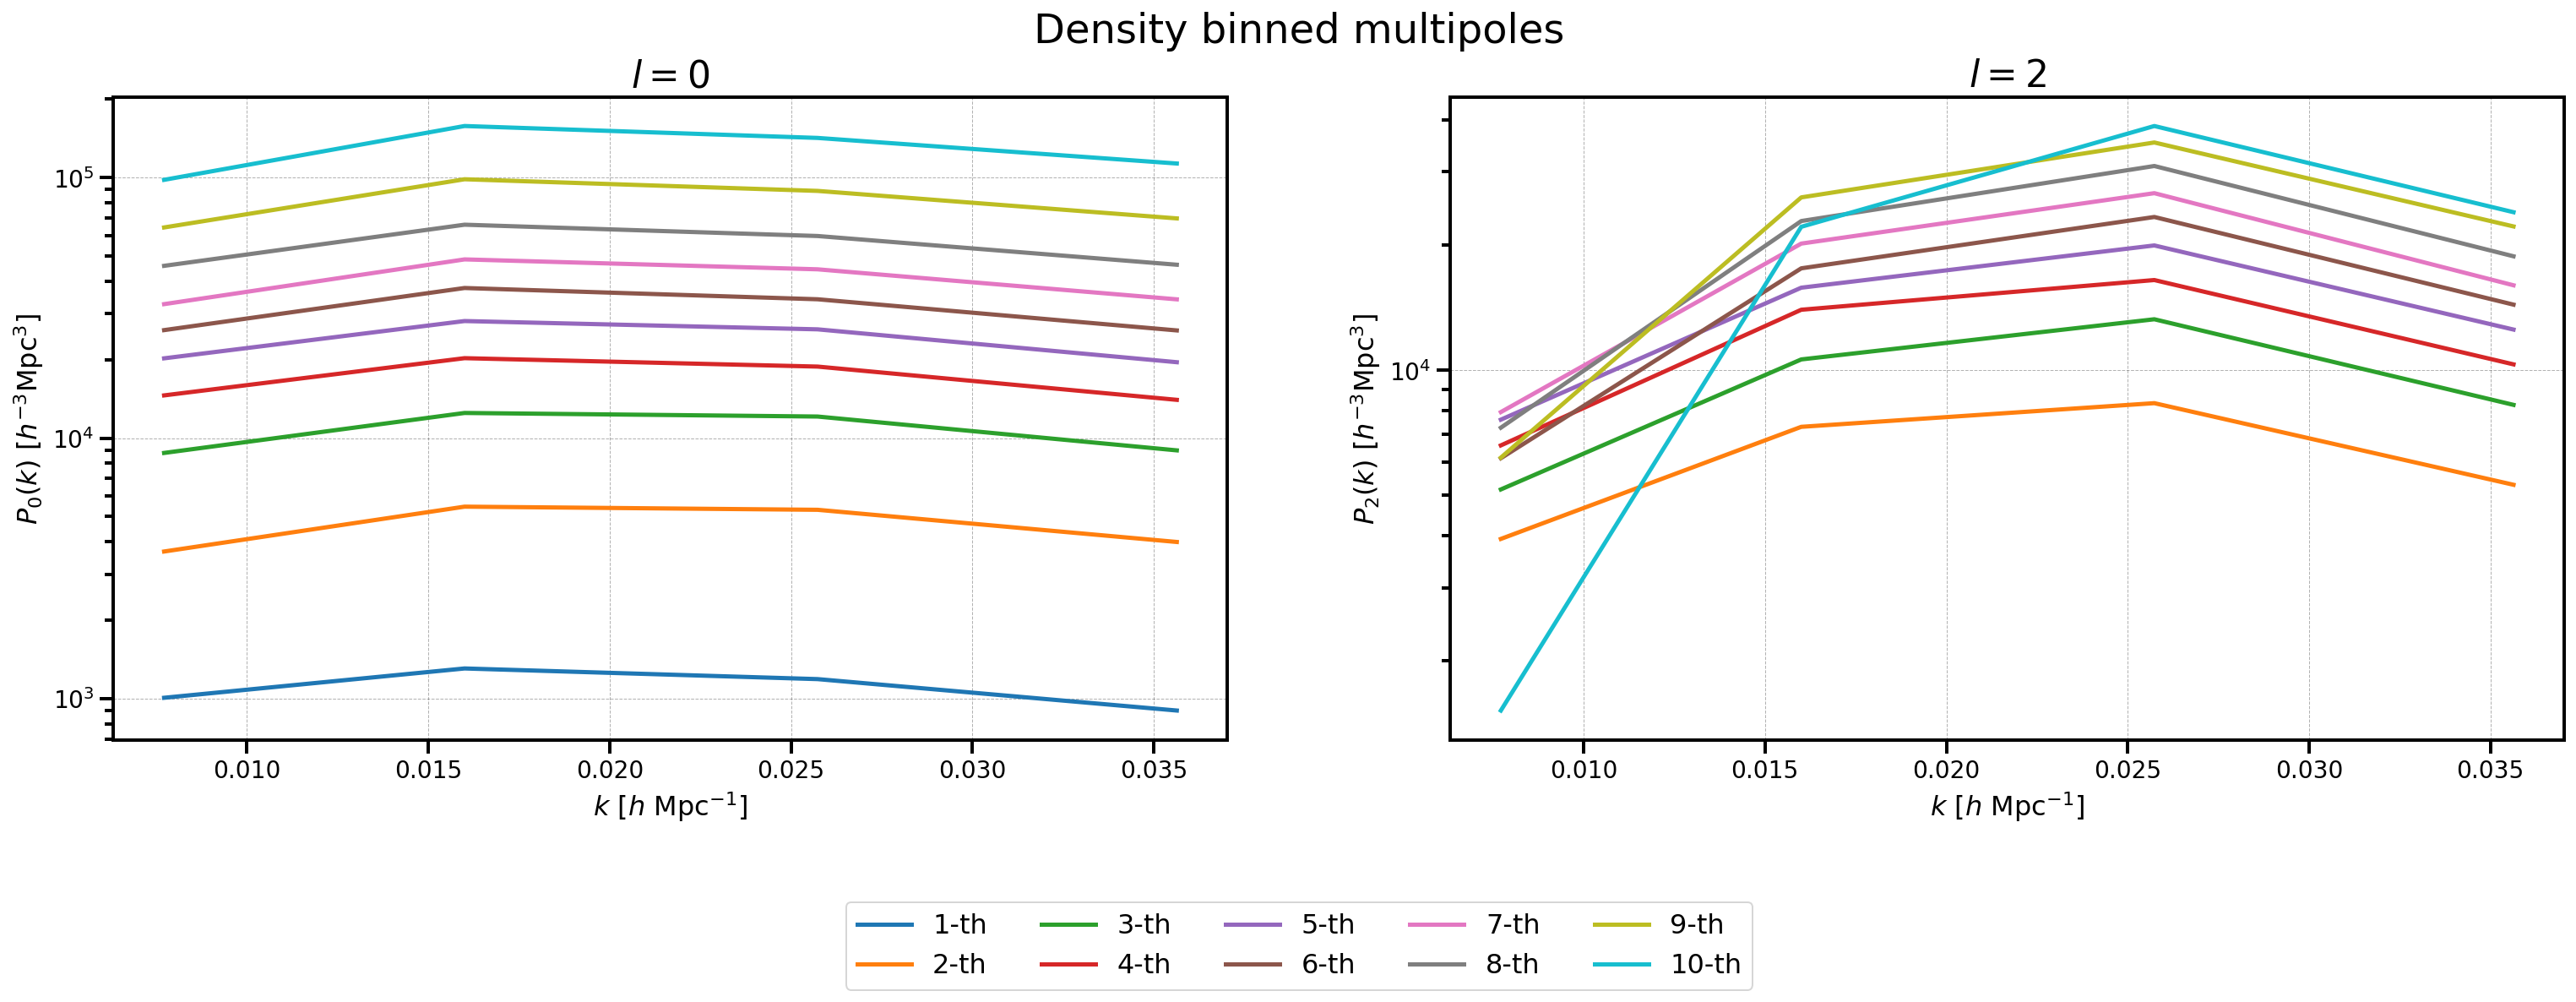

In [7]:
fig, axs = plt.subplots(1, len(ells), figsize=(26,7))

for j, ell in enumerate(ells):
    for i in range(n_ptile):
        axs[j].plot(k, Pk_ells[i][j], label='%d-th'%(i+1))
        
    #axs[j].set_title("Density separated multipole $l=%d$"%ell)
    axs[j].set_title("$l=%d$"%ell)
    axs[j].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
    axs[j].set_ylabel(r"$P_%d(k)$ [$h^{-3}\mathrm{Mpc}^3$]"%ell)
    axs[j].set_yscale('log')
    
fig.suptitle('Density binned multipoles', fontsize=24)
handles, labels = axs[j].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.show()
#fig.savefig("plots/multipoles_densities_binned.pdf")

### Interpretation
As the density increases, the power spectrum amplitude increases. This is expected since in high density regions are regions of enhanced clustering. Since the power spectrum is the FT of the 2 point correlation function, whose amplitude measures the amount of clustering. For greater amounts of clustering we expect to need a larger value of the bias to reproduce the multipole with the model.

Note that when computing for large $k$ we find some multipoles to become negative, which cannot be reproduced by the model. On a log scale this is manifested as a cut of the multipole plot and occurs for:
- $l=0:$ 1st percentile $k\approx 0.2$
- $l=2:$ 9st percentile $k\approx 0.145$, 10st percentile $k\approx 0.08$

To ensure sensible fitting parameters, only consider up to $k \approx 0.05$ i.e. slice `k[:5]`

### Fit b1 and beta for each density bin and multipole
Fitting $\beta$ is effectively the same as fitting the growth rate $f$ at $z=0$ as $\beta \equiv \frac{f_0}{b1}$.
Fitting procedure is analogous to `Fitting_b1.ipynb` but now having 2 free parameters. The linear theory predictions for the multipoles are (eq 5.7 in Hamilton's review):

$$
P_0^s(k) = (1 + \frac{2}{3}\beta + \frac{1}{5}\beta^2 )P(k), \quad P_2^s(k) = ( \frac{4}{3}\beta + \frac{4}{7}\beta^2 )P(k)
$$

where the real space power spectrum $P(k)$ is related to the matter power spectrum $P_m(k)$ via $P(k) = b1^2P_m(k)$. Note that in `Fitting_b1_different_kmax.ipynb`, these multipoles have not been hardcoded but computed by projection on Legendre polynomials. 

In [8]:
def make_Pkmu(k, b1, beta):
    '''Make 2D array containing the model P(k,mu) with rows iterating k bins and columns iterating mu bins.
    Later seek to integrate up each row i.e. integrate over mu. Nmu defines the discretiation.'''
    Nmu = 51
    mus = np.linspace(-1,1,Nmu)
    Pkmu = np.empty((len(k), Nmu))
    
    for i,mu in enumerate(mus):
        Pkmu[:,i] = (1 + beta*mu**2)**2 *b1**2 * Plin(k)
        
    return Pkmu, mus


def per_mode_cov(k, l1, l2, b1, beta, shotnoise, dk):
    '''Construct per mode covariance. See eq 15, 16 (for factor f) of Grieb et al. (2016).'''
    V = BoxSize**3
    V_k = 4/3*np.pi*((k+dk/2)**3 - (k-dk/2)**3)
    f = 2*(2*np.pi)**4 / V_k**2 * k**2 * dk
    Pkmu, mus = make_Pkmu(k, b1, beta)
    L_l1, L_l2 = legendre(l1)(mus), legendre(l2)(mus)
    integrand = (Pkmu + shotnoise)**2 * L_l1*L_l2
    
    return f*(2*l1+1)**2 * (2*l2+1)**2 / V * simpson(integrand, mus) # 1D array containing per mode cov for each k bin


def gaussian_cov_mat_inv(k, ells, b1, beta, shotnoise, dk):
    '''See above markdown for explanation of structure of covariance matrix. Uses sparse matricies for fast inversion.
    scipy.sparse.bmat allows to combine matricies by passing structure of larger matrix in terms of submatricies.'''
    # initialize array accepting matricies as elements and fill with diagonal C_l1,l2 matricies
    C = np.empty((len(ells), len(ells)), dtype='object')
    for i,l1 in enumerate(ells):
        for j,l2 in list(enumerate(ells))[i:]:
            C[i][j] = ss.diags(per_mode_cov(k,l1,l2,b1,beta,shotnoise,dk))
            if j!=i:
                C[j][i] = C[i][j]
                
    cov_mat = ss.bmat(C).tocsc() # convert to efficient scipy matrix format
    
    # deal with inverting signular matrix
    try: 
        inv = ss.linalg.inv(cov_mat).toarray()
    except RuntimeError:
        inv = pinv(cov_mat.toarray())
        
    return inv
    
    
def chi2(x, k, data_multipoles, shotnoise, dk):
    '''Find chi^2 as explained in Fitting_b1.ipynb. data_multipoles must be an array of shape (len(ells), len(k)).
    x is an array containing the parameters to be fitted: x = [b1, beta].
    Due to hard coding multipoles, only works for ells = [0,2]'''
    b1, beta = x[0], x[1]
    ells = [0,2]
    # make model vector
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
    model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)
        
    D_M = (data_multipoles - model_multipoles).flatten()
    C_inv = gaussian_cov_mat_inv(k, ells, b1, beta, shotnoise, dk)
    
    return D_M@(C_inv @ D_M)

In [9]:
b1_fits, beta_fits, chi2_mins = np.empty(n_ptile), np.empty(n_ptile), np.empty(n_ptile)

for i in range(n_ptile):
    t1 = time.time()
    # change data format of Pk_ells to be compatible with chi2 minimization code 
    data_multipoles = np.empty((len(ells), len(k)))
    data_multipoles[0] = Pk_ells[i][0]
    data_multipoles[1] = Pk_ells[i][1]
    s = minimize(chi2, [1, 0.5], args=(k, data_multipoles, shotnoise, dk), bounds=((None, None), (None, None)))
    b1_fits[i] = s.x[0]
    beta_fits[i] = s.x[1]
    chi2_mins[i] = s.fun
    t2 = time.time()
    print("Fitted %d-th percentile in %.2f sec"%(i+1,t2-t1))

Fitted 1-th percentile in 2.12 sec
Fitted 2-th percentile in 1.41 sec
Fitted 3-th percentile in 2.51 sec
Fitted 4-th percentile in 1.32 sec
Fitted 5-th percentile in 1.17 sec
Fitted 6-th percentile in 1.26 sec
Fitted 7-th percentile in 1.26 sec
Fitted 8-th percentile in 1.31 sec
Fitted 9-th percentile in 1.24 sec
Fitted 10-th percentile in 1.64 sec


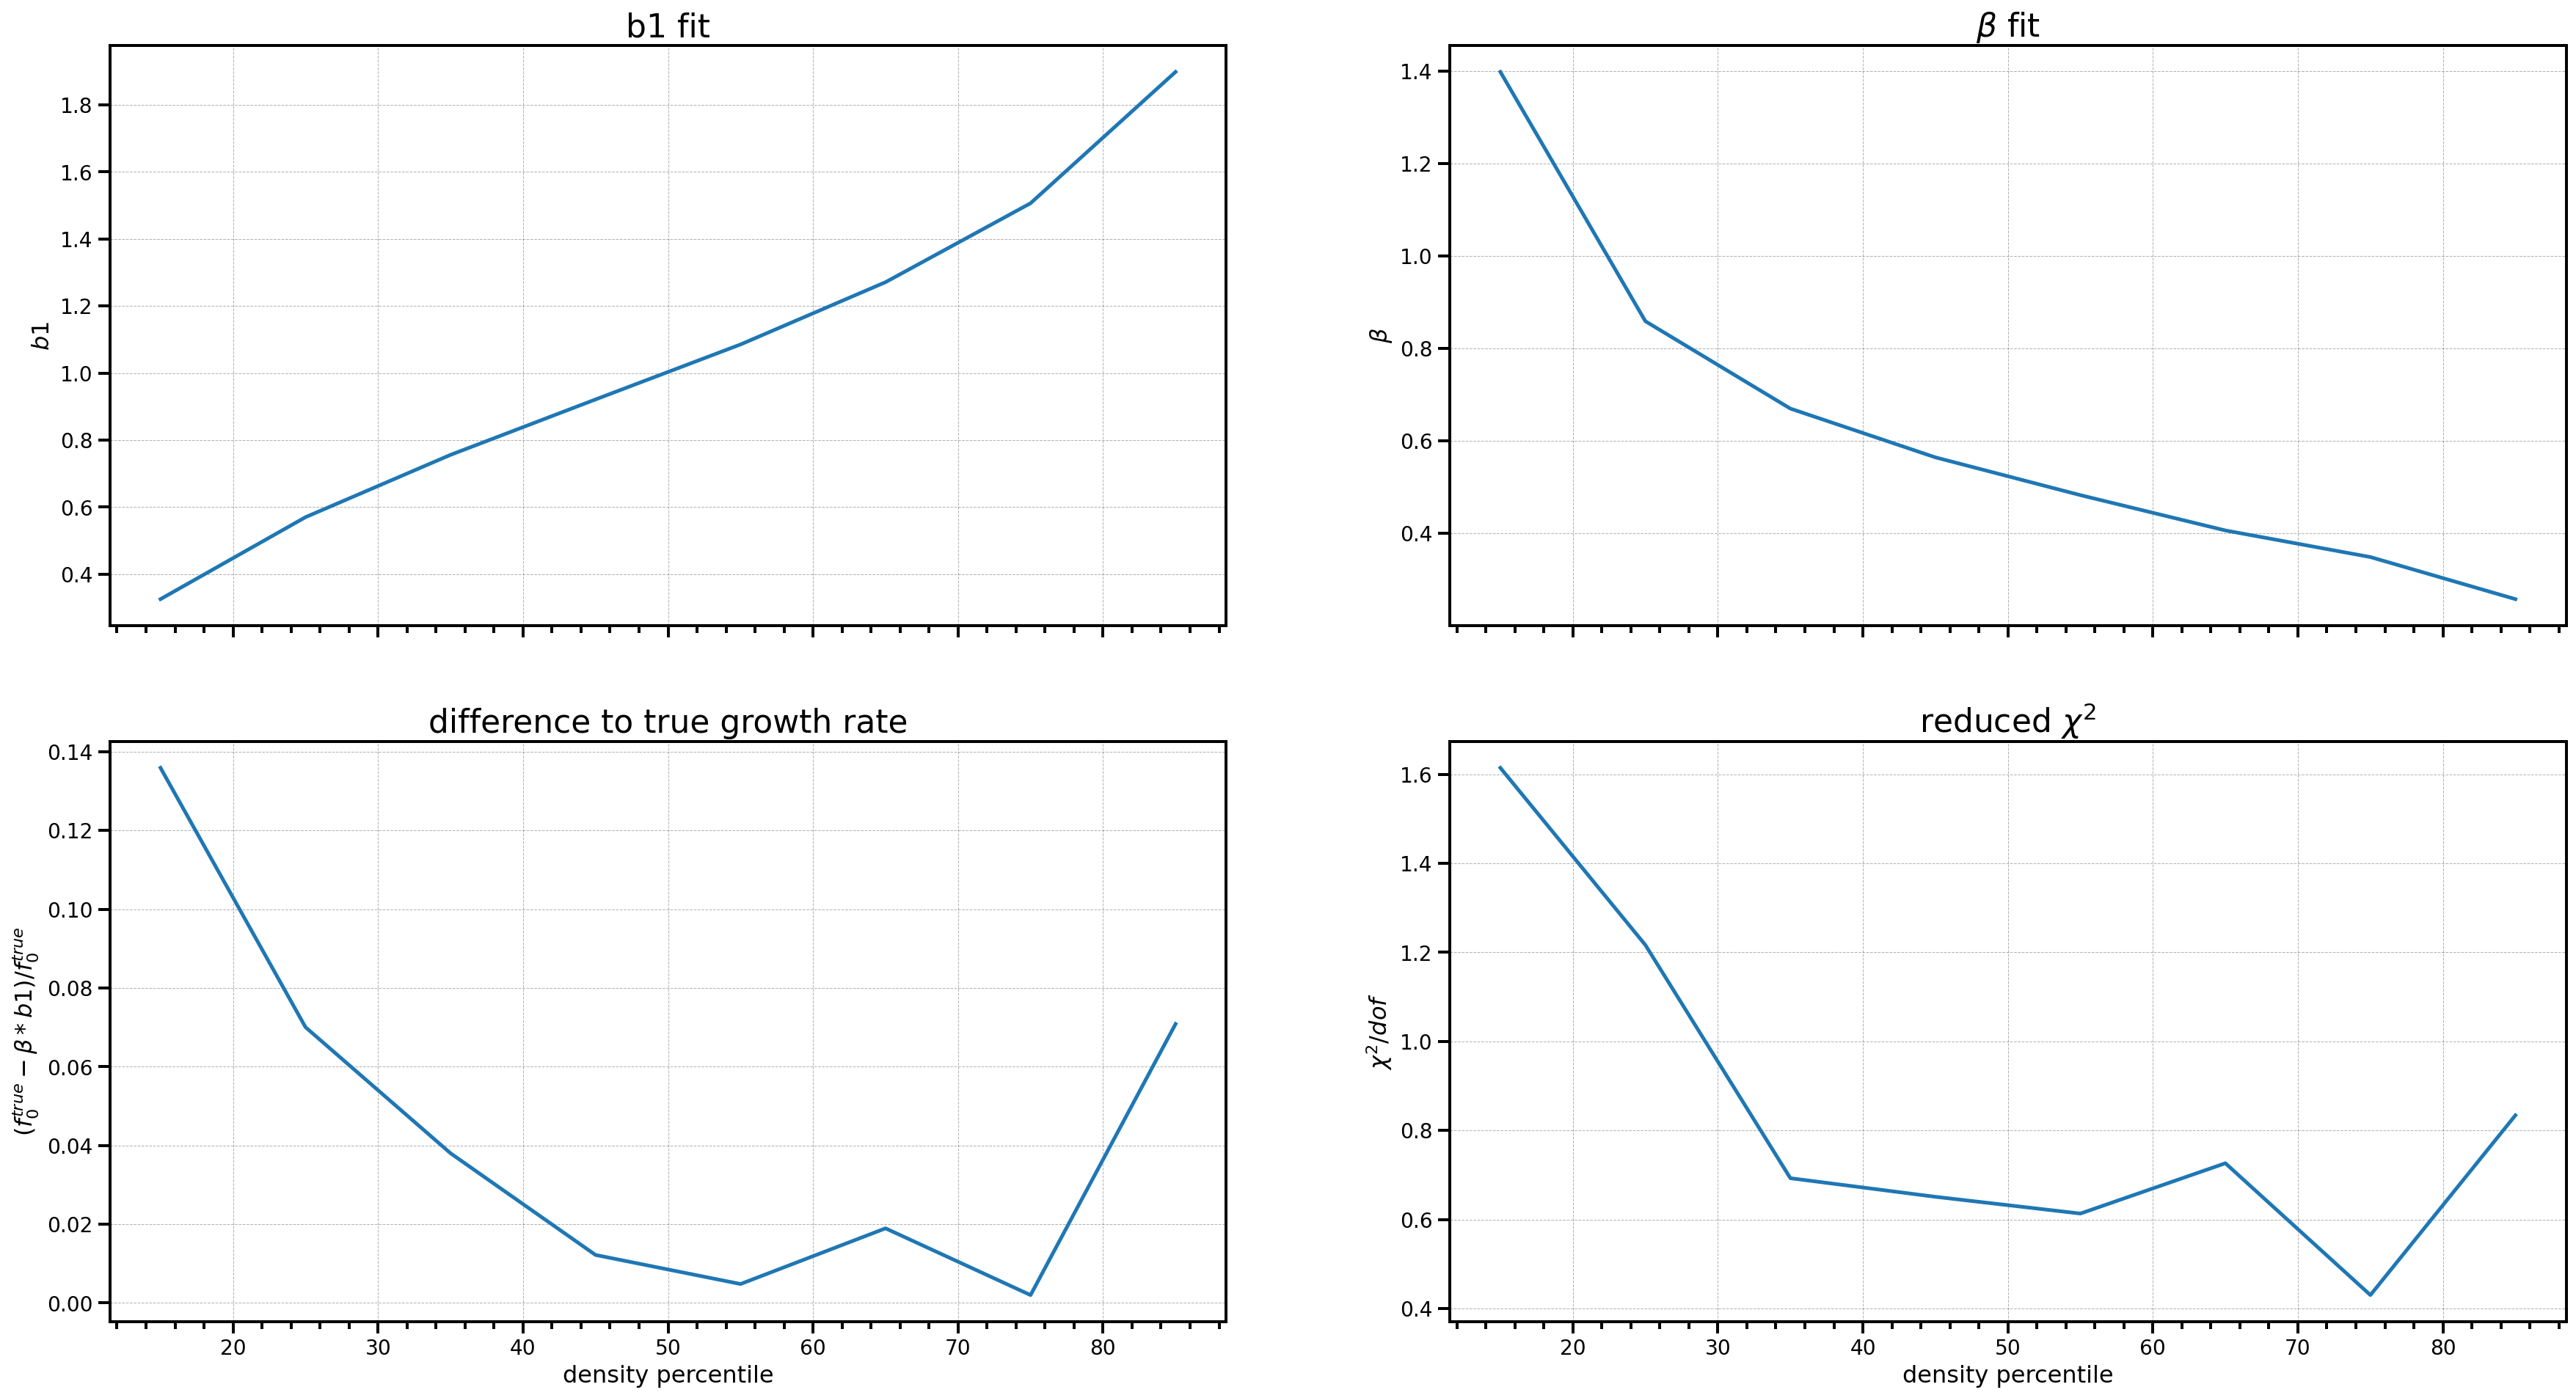

In [10]:
from matplotlib.ticker import AutoMinorLocator
fig, axs = plt.subplots(2, 2, figsize=(30,16), sharex=True)

mids = np.arange(5,105,10)[1:-1] # percentile mid points

axs[0][0].plot(mids, b1_fits[1:-1])
axs[0][0].set_title("b1 fit")
#axs[0][0].set_xlabel("density percentile")
axs[0][0].set_ylabel(r"$b1$")

axs[0][1].plot(mids, beta_fits[1:-1])
axs[0][1].set_title(r"$\beta$ fit")
#axs[0][1].set_xlabel("density percentile")
axs[0][1].set_ylabel(r"$\beta$")

f0_true = cosmo.scale_independent_growth_rate(redshift)
axs[1][0].plot(mids, (f0_true - (beta_fits*b1_fits)[1:-1]) / f0_true)
axs[1][0].set_title(r"difference to true growth rate")
axs[1][0].set_xlabel("density percentile")
axs[1][0].set_ylabel(r"$(f^{true}_0 - \beta*b1)/f^{true}_0$")
axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())

# For each of l=0,2 we have data_multipoles.shape[1] k bins. Fitting two parameters gives DOF
reduced_chi2 = chi2_mins/(2*data_multipoles.shape[1] - 2)
axs[1][1].plot(mids, reduced_chi2[1:-1])
axs[1][1].set_title("reduced $\chi^2$")
axs[1][1].set_xlabel("density percentile")
axs[1][1].set_ylabel(r"$\chi^2 / dof$")
axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())

plt.show()
#fig.savefig('plots/Fitting_b1_beta_densitybins_minchi2.pdf')

### Interpretation
Without negative multipoles (i.e kmax=0.05) and ignoring the first percentile, get okay fitted parameters and reduced chi2 of around 1. The quality of the first near the end density bins is not good as see in f0 plot. A potential reason why f0 is systematically underestimated could be not including a "Finger of God" term in model. FOG cause RSD to be diluted such that a lower growth rate is inferred.

The issue with the first percentile is the quadrupole is entirely negative, causing a negative beta is fitted. Even though the resulting chi2 is small, the inferred f0 is far off. Bounding beta to be non-negative gives beta=0 in the 1st percentile, causing $P_0^{model}(k) \sim P_{matter}(k), P_2^{model}(k) = 0$ and hence a large $\chi^2$.